In [107]:
from skimage import img_as_uint, img_as_ubyte, img_as_bool, img_as_float
from skimage.io import imread, imshow, imsave, find_available_plugins
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity
from skimage.viewer import ImageViewer
from skimage.filters import try_all_threshold, gabor, threshold_otsu, threshold_mean, threshold_minimum, \
threshold_local, frangi, gaussian  
from skimage.morphology import skeletonize, skeletonize_3d, thin, disk
from skimage.util import invert
from skimage.feature import canny, orb
from skimage.filters.rank import enhance_contrast, autolevel
from skimage.segmentation import felzenszwalb
from PIL import Image, ImageDraw
import shutil 

import os
import numpy as np
#sns.set(style='whitegrid')
import json

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = {'png', 'retina'}

In [108]:
%matplotlib inline

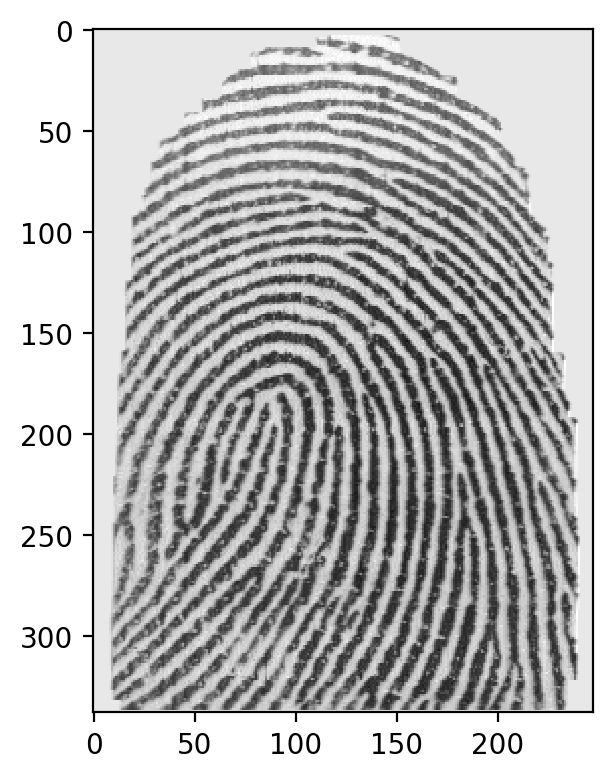

In [109]:
img = imread("data/raw_data/png/1_8.png", as_grey = True)
imshow(img)

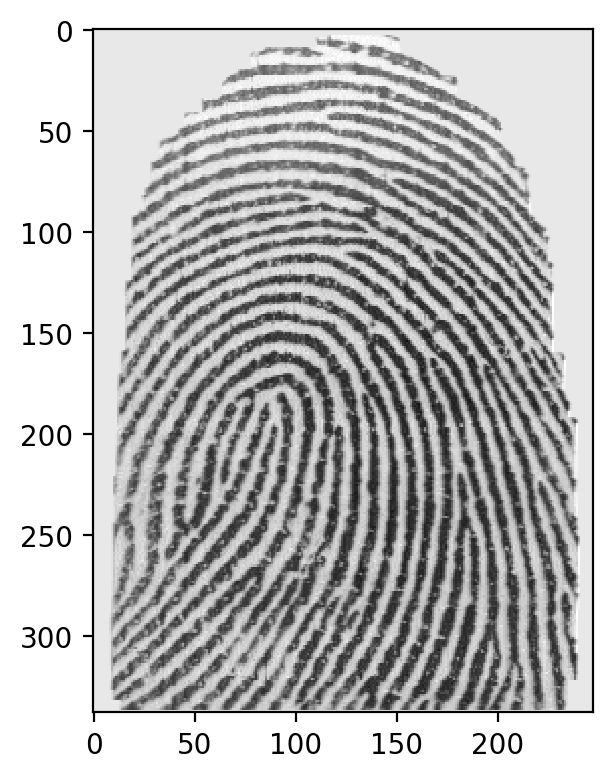

In [110]:
img_intensity_scale = rescale_intensity(img, in_range= "dtype")

imshow(img_intensity_scale)

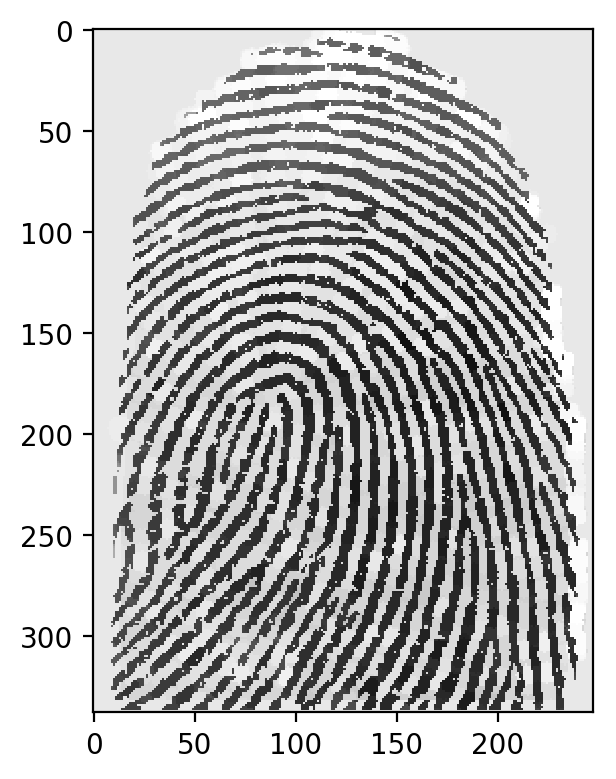

In [111]:
img_enhanced_contrast = enhance_contrast(img_intensity_scale, disk(5))

imshow(img_enhanced_contrast)

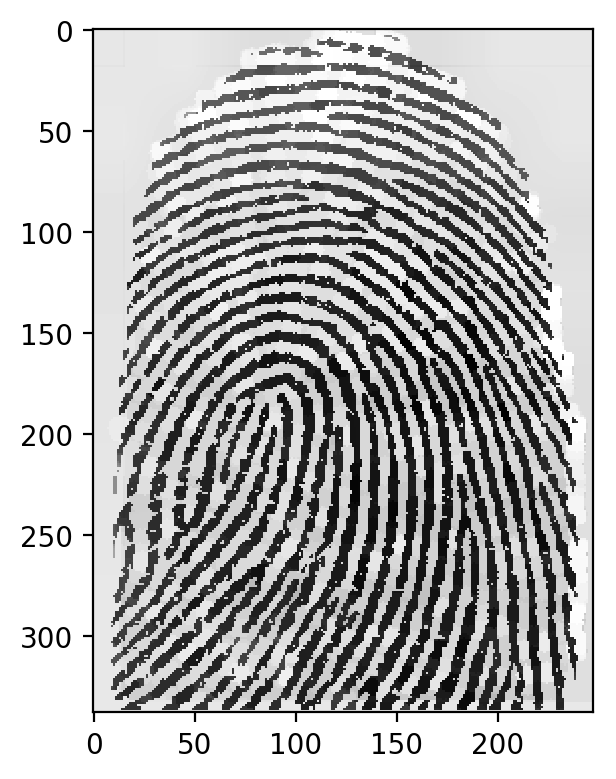

In [112]:
img_equalized = equalize_adapthist(img_enhanced_contrast, clip_limit= 0.01)
imshow(img_equalized)

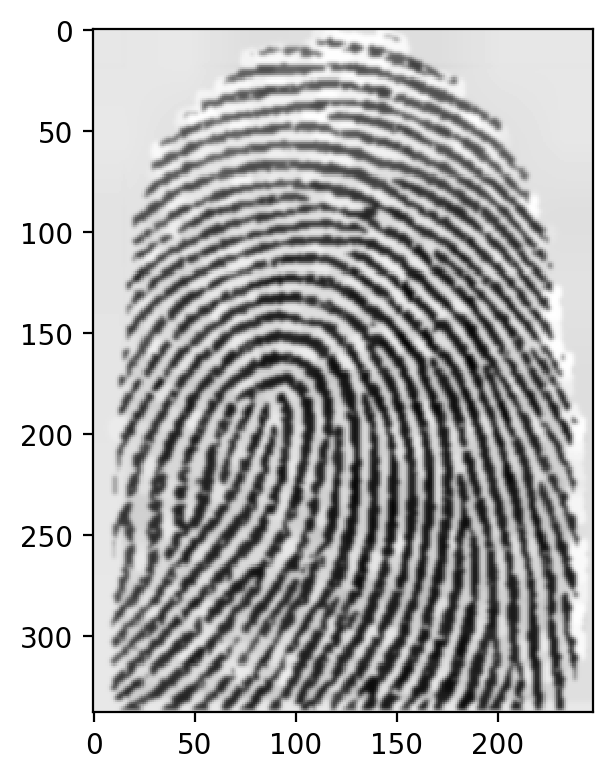

In [113]:
img_smoothed = gaussian(img_equalized)

imshow(img_smoothed)

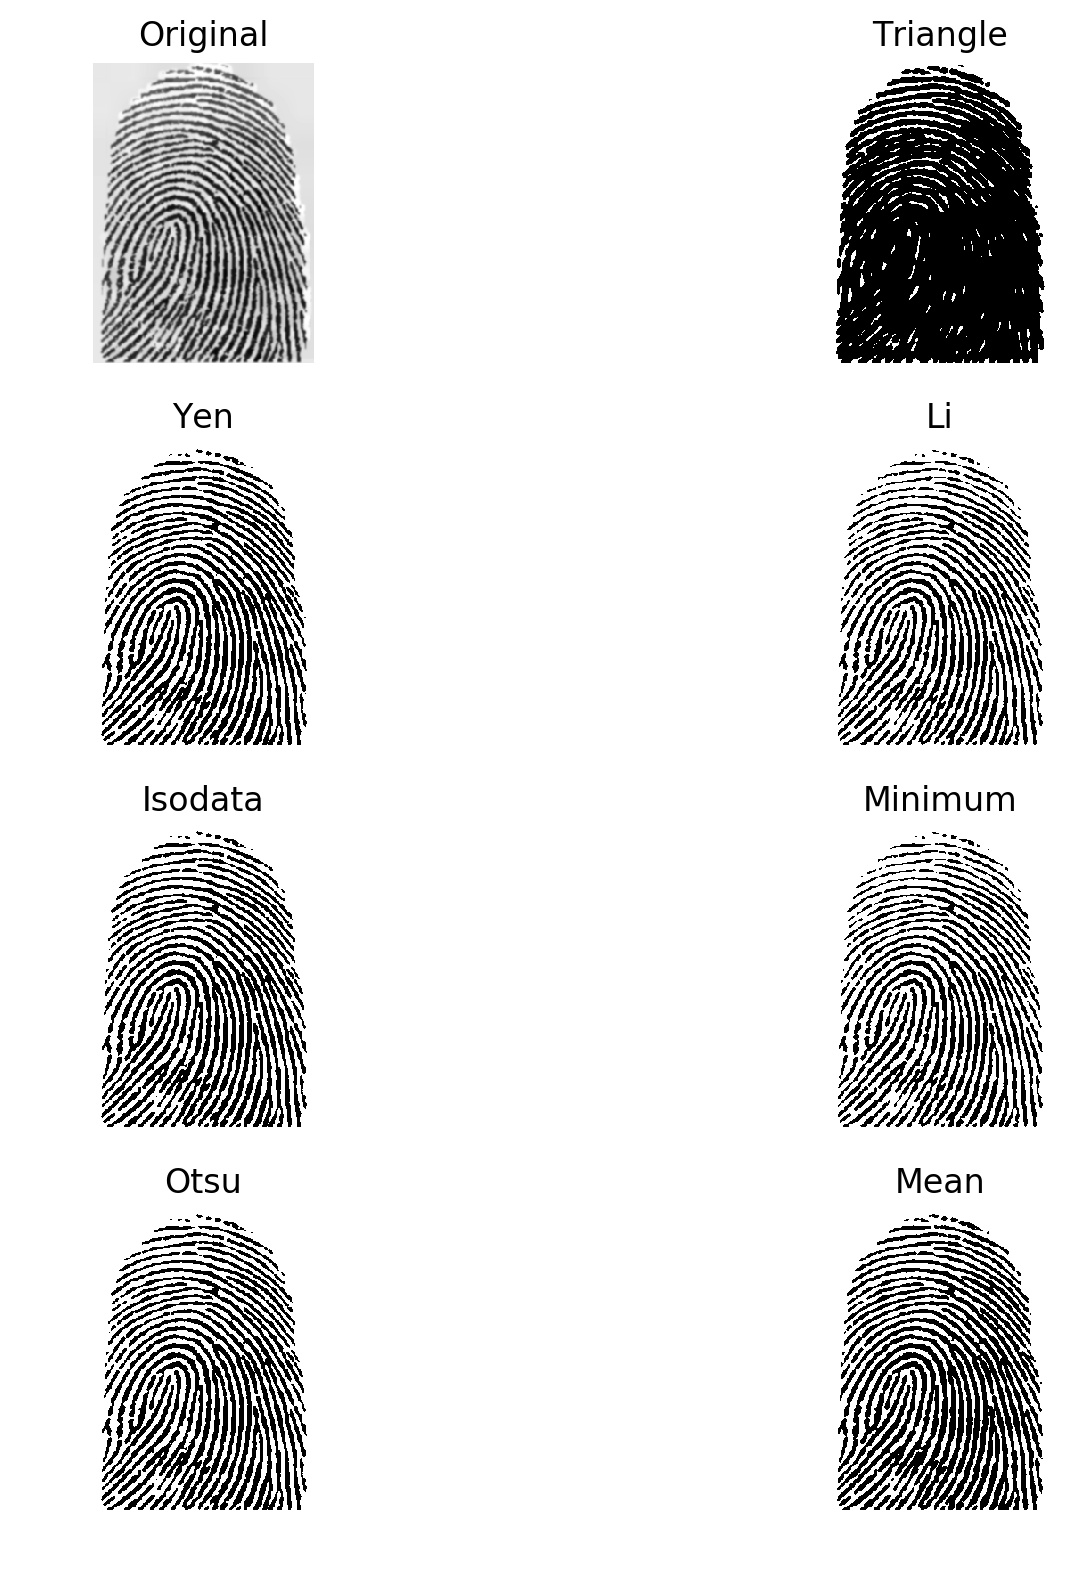

In [114]:
fig, ax = try_all_threshold(img_smoothed, figsize=(10, 8), verbose=False)
plt.show()

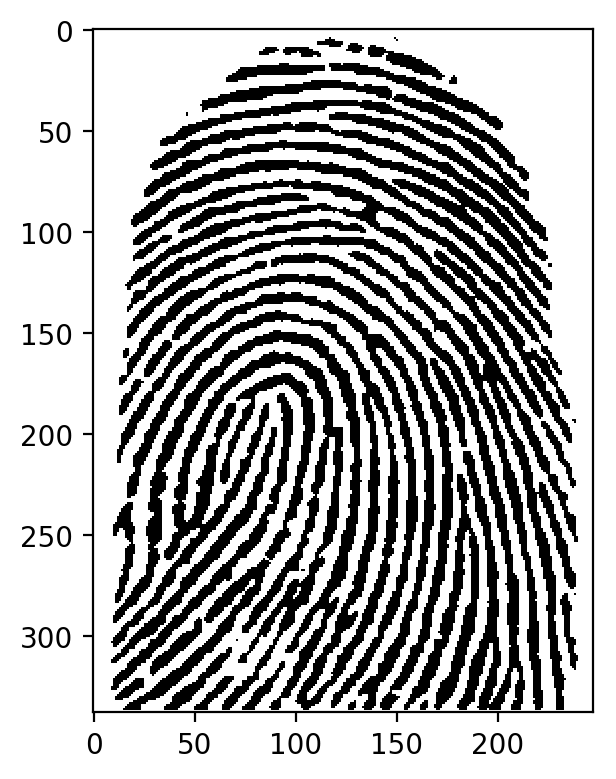

In [115]:
thresh_local = threshold_local(img_smoothed, 125, 'mean', mode = "reflect")
img_binarized = img_smoothed > thresh_local

imshow(img_binarized)

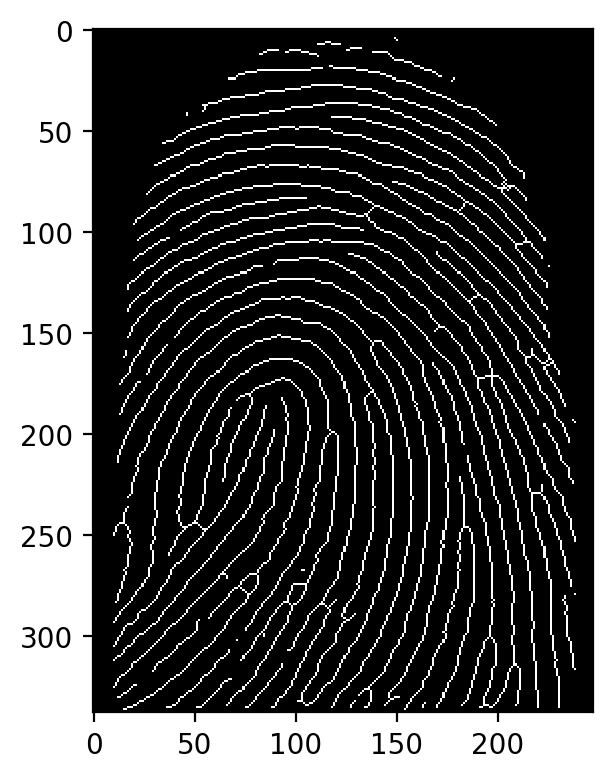

In [116]:
img_thinned = thin(invert(img_binarized))

imshow(img_thinned)

In [157]:
from verify import run_simulation, load_config
from core import match
import collections

import pandas as pd
import numpy as np

def compute_match_scores(results, threshold):
    match_scores = [1 if raw_score >= threshold else 0 for raw_score in results.scores]
    return match_scores

def compute_FNMR(match_scores):
    FNMR = 100-compute_FMR(match_scores)
    return FNMR

def compute_FMR(match_scores):
    FMR = (float(sum(match_scores))/(len(match_scores)))*100
    return FMR

if __name__=="__main__":
    config = load_config()
    db = config["db"]

    #genuine_results = run_simulation(matcher, db, True)
    #fraud_results = run_simulation(matcher, db, False)
    genuine_results = pd.read_csv("results/results_png_genuine.csv",sep='\t', index_col = 0)
    fraud_results = pd.read_csv("results/results_png_fraud.csv",sep='\t', index_col = 0)
    
    thresholds = [round(thresh,2) for thresh in np.arange(0.0, 1.01, 0.01)]
    FNMR_rates= []
    FMR_rates= []
    for threshold in thresholds:
        match_scores = [compute_match_scores(results,threshold) for results in [genuine_results,fraud_results]]
        FNMR_rates.append(compute_FNMR(match_scores[0]))
        FMR_rates.append(compute_FMR(match_scores[1]))


In [158]:
df = pd.DataFrame({"threshold":thresholds,"FNMR":FNMR_rates,"FMR":FMR_rates})
df.head()

,FMR,FNMR,threshold
0,82.142857,0.892857,0.00
1,82.142857,0.892857,0.01
2,82.142857,0.892857,0.02
3,82.142857,0.892857,0.03
4,80.357143,0.892857,0.04


In [160]:
poly_1 = np.polyfit(df.threshold, df.FMR, deg=2)
poly_2 = np.polyfit(df.threshold, df.FNMR, deg=2)

df["FMR_fitted"]  = np.polyval(poly_1, df.threshold)
df["FNMR_fitted"]  = np.polyval(poly_2, df.threshold)

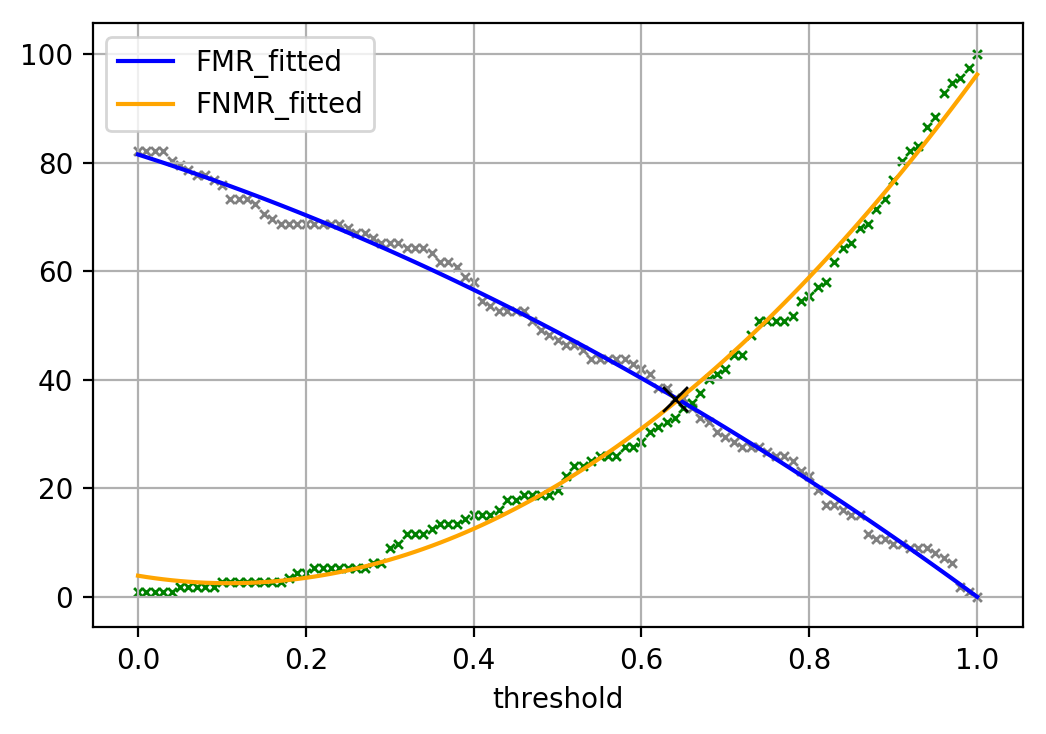

In [163]:
df.plot(x="threshold",y =["FMR_fitted","FNMR_fitted"], kind='line', grid = True, color = ["blue","orange"])
plt.scatter(df["threshold"], df["FMR"], marker='x', s=10, zorder=1, 
            linewidth=1, color='grey')
plt.scatter(df["threshold"], df["FNMR"], marker='x', s=10, zorder=1, 
            linewidth=1, color='green')

plt.scatter(x = 0.64, y = 36.5, marker='x', s=80, zorder=5, 
            linewidth=1, color='black')